In [15]:
!pip install pandas google-cloud-bigquery
!pip install pandas-gbq


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import pandas as pd
from google.oauth2 import service_account
import pandas as pd
import pandas_gbq as gbq
import json
from pandas_gbq import to_gbq
from pandas_gbq import read_gbq
import matplotlib.pyplot as plt
import seaborn as sns

credentials_path = '../token.json'

# Authenticate with your credentials
credentials = service_account.Credentials.from_service_account_file(
    credentials_path, scopes=['https://www.googleapis.com/auth/bigquery'])

# Set the credentials for pandas_gbq
gbq.context.credentials = credentials

In [11]:
cri_data = read_gbq(f"""

SELECT *
FROM capstone-402105.capstone.cri_data

""",project_id='capstone-402105', dialect='standard')

Downloading: 100%|██████████|


In [ ]:
compustat_data = read_gbq(f"""

SELECT *
FROM capstone-402105.capstone.compustat_data

""",project_id='capstone-402105', dialect='standard')

In [20]:
# cri_data = pd.read_pickle('cri_data.pkl')

In [21]:
# compustat_data = pd.read_pickle('compustat_inputed_v8.pkl')

In [22]:
compustat_data.shape

(784752, 30)

In [25]:
# convert to monthly 
def expand_dates(ser):
    min_date = ser['datadate'].min()
    max_date = ser['datadate'].max()
    return pd.DataFrame({'datadate': pd.date_range(min_date, max_date, freq='M')})

# Apply the function within each 'id' group
ffdf = compustat_data.groupby(['gvkey']).apply(expand_dates).reset_index()

# Merge with the original DataFrame and forward fill missing values for the entire row
result = ffdf.merge(compustat_data, on=['gvkey', 'datadate'], how='left').fillna(method='ffill')
result['mm'] = result['datadate'].dt.month
result.drop('level_1', axis=1, inplace=True)
result.head()

C:\Users\shiho\AppData\Local\Temp\ipykernel_19428\173701593.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result = ffdf.merge(compustat_data, on=['gvkey', 'datadate'], how='left').fillna(method='ffill')


,gvkey,datadate,sic,tic,year,quarter,current_ratio,quick_ratio,cash_ratio,net_working_capital,...,working_capital_turnover,price_to_earnings,dividend_payout_ratio,retention_ratio,gross_margin_ratio,operating_profit_margin,ebitda_margin,debt_service_coverage_ratio,interest_coverage_ratio,mm
0,1004,2000-02-29,5080.0,AIR,2000.0,1.0,2.981531,1.176928,-0.021609,350.202,...,0.616739,59.375000,0.212500,0.787500,18.234795,-72.491564,-70.807951,-0.958372,4.223950,2
1,1004,2000-03-31,5080.0,AIR,2000.0,1.0,2.981531,1.176928,-0.021609,350.202,...,0.616739,59.375000,0.212500,0.787500,18.234795,-72.491564,-70.807951,-0.958372,4.223950,3
2,1004,2000-04-30,5080.0,AIR,2000.0,1.0,2.981531,1.176928,-0.021609,350.202,...,0.616739,59.375000,0.212500,0.787500,18.234795,-72.491564,-70.807951,-0.958372,4.223950,4
3,1004,2000-05-31,5080.0,AIR,2000.0,2.0,3.120983,1.069792,-0.042786,347.451,...,0.645246,154.166667,0.944444,0.055556,18.944015,-75.280235,-73.157425,-0.819497,2.287927,5
4,1004,2000-06-30,5080.0,AIR,2000.0,2.0,3.120983,1.069792,-0.042786,347.451,...,0.645246,154.166667,0.944444,0.055556,18.944015,-75.280235,-73.157425,-0.819497,2.287927,6


In [26]:
result.shape

(2366356, 31)

In [27]:
inf_breakdown = pd.DataFrame()
inf_breakdown['pct_inf'] = (100 * result.isin([float('inf'), float('-inf')]).sum()) / len(compustat_data)
inf_breakdown

,pct_inf
gvkey,0.0
datadate,0.0
sic,0.0
tic,0.0
year,0.0
quarter,0.0
current_ratio,0.0
quick_ratio,0.0
cash_ratio,0.0
net_working_capital,0.0


In [17]:
# company_map = pd.read_csv('./compustat_company_map.xlsx - in.csv')
# company_map.head()


company_map = read_gbq(f"""

SELECT *
FROM capstone-402105.raw_data.company_map

""",project_id='capstone-402105', dialect='standard')

Downloading: 100%|██████████|


In [45]:
with open('../token.json', 'r') as token_file:
    token_data = json.load(token_file)
    project_id = token_data.get('project_id', 'default-project-id')

dataset_id = "raw_data"
table_id = 'company_map'

to_gbq(company_map, destination_table=f'{project_id}.{dataset_id}.{table_id}', project_id=project_id, if_exists='replace')

100%|██████████| 1/1 [00:00<?, ?it/s]


In [18]:
# mapping from company number to gvkey
mapping_dict = company_map.set_index('company_number')['gvkey'].to_dict()

In [22]:
cri_data['gvkey'] = cri_data['CompNo'].map(mapping_dict)

In [23]:
cri_data = cri_data.dropna()
cri_data.shape # lost about 300k rows from missing mapping values, ie 13%

(1943733, 31)

In [29]:
# clean compustat
result.rename(columns = {'mm': 'month'}, inplace=True)
result.drop(columns = ['datadate', 'quarter', 'sic'], inplace=True)
result.head()

,gvkey,tic,year,current_ratio,quick_ratio,cash_ratio,net_working_capital,debt_ratio,debt_to_equity_ratio,equity_ratio,...,working_capital_turnover,price_to_earnings,dividend_payout_ratio,retention_ratio,gross_margin_ratio,operating_profit_margin,ebitda_margin,debt_service_coverage_ratio,interest_coverage_ratio,month
0,1004,AIR,2000.0,2.981531,1.176928,-0.021609,350.202,0.273288,0.601468,0.454368,...,0.616739,59.375000,0.212500,0.787500,18.234795,-72.491564,-70.807951,-0.958372,4.223950,2
1,1004,AIR,2000.0,2.981531,1.176928,-0.021609,350.202,0.273288,0.601468,0.454368,...,0.616739,59.375000,0.212500,0.787500,18.234795,-72.491564,-70.807951,-0.958372,4.223950,3
2,1004,AIR,2000.0,2.981531,1.176928,-0.021609,350.202,0.273288,0.601468,0.454368,...,0.616739,59.375000,0.212500,0.787500,18.234795,-72.491564,-70.807951,-0.958372,4.223950,4
3,1004,AIR,2000.0,3.120983,1.069792,-0.042786,347.451,0.279030,0.608989,0.458186,...,0.645246,154.166667,0.944444,0.055556,18.944015,-75.280235,-73.157425,-0.819497,2.287927,5
4,1004,AIR,2000.0,3.120983,1.069792,-0.042786,347.451,0.279030,0.608989,0.458186,...,0.645246,154.166667,0.944444,0.055556,18.944015,-75.280235,-73.157425,-0.819497,2.287927,6


In [30]:
# clean compustat
cri_data.rename(columns = {'mm': 'month'}, inplace=True)
cri_data.rename(columns = {'yyyy': 'year'}, inplace=True)

In [31]:
cri_data.head()

,CompNo,year,month,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,EventDate,Default_1,Default_3,Default_6,Default_12,Default_24,Default_36,Default_60,Duration,gvkey
0,26986,1991.0,1,0.045126,0.013825,0.576320,0.0,0.0,0.0,0.000618,...,1991-01-31 00:00:00+00:00,0,0,0,0,0,0,0,1123,1177.0
1,27005,1991.0,1,0.045126,0.013825,3.101486,0.0,0.0,0.0,-0.001718,...,1991-01-31 00:00:00+00:00,0,0,0,0,0,0,0,1123,1257.0
2,27033,1991.0,1,0.045126,0.013825,2.236715,0.0,0.0,0.0,0.002089,...,1991-01-31 00:00:00+00:00,0,0,0,0,0,0,0,1123,1474.0
3,27037,1991.0,1,0.045126,0.013825,2.342777,0.0,0.0,0.0,0.003752,...,1991-01-31 00:00:00+00:00,0,0,0,0,0,0,0,1123,13709.0
4,27078,1991.0,1,0.045126,0.013825,2.404157,0.0,0.0,0.0,0.004008,...,1991-01-31 00:00:00+00:00,0,0,0,0,0,0,0,1123,12334.0


In [32]:
# left join on gvkey, year, month where left is CRI data, right is compustat
cri_compustat_merged = cri_data.merge(result, how='inner')

In [33]:
cri_compustat_merged.head()

,CompNo,year,month,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,day_sales_outstanding,working_capital_turnover,price_to_earnings,dividend_payout_ratio,retention_ratio,gross_margin_ratio,operating_profit_margin,ebitda_margin,debt_service_coverage_ratio,interest_coverage_ratio
0,27006,2000.0,1,0.089239,0.011089,3.534217,1.722983,0.0,0.0,0.002291,...,0.000000,-0.190504,-685.000000,-0.000000,1.000000,1.031492,-97.937015,-85.674822,-0.375891,3.552221
1,27030,2000.0,1,0.089239,0.011089,3.022648,0.032250,0.0,0.0,0.001534,...,11.568091,-0.109201,109.875000,0.160000,0.840000,14.080814,-71.838371,-32.604990,-0.112946,1.862309
2,27116,2000.0,1,0.089239,0.011089,-0.175921,-0.042937,0.0,0.0,0.000365,...,6213.764908,0.303945,33.777574,0.110294,0.889706,60.432309,20.864618,22.390374,0.005115,1.251008
3,27162,2000.0,1,0.089239,0.011089,6.950984,-0.174204,0.0,0.0,0.003562,...,0.000000,0.558946,113.169643,1.517857,-0.517857,50.368747,0.737495,-1.974225,0.000502,1.812797
4,27431,2000.0,1,0.089239,0.011089,2.010912,0.196004,0.0,0.0,0.007752,...,0.000000,2.867117,69.693396,0.188679,0.811321,13.090258,-73.819484,-70.701158,-5.213948,5.984436


In [34]:
cri_compustat_merged.shape #lost about 760249 rows, or 39%

(1178925, 56)

In [35]:
len(cri_compustat_merged['gvkey'].unique())

10894

In [36]:
inf_breakdown = pd.DataFrame()
inf_breakdown['pct_inf'] = (100 * cri_compustat_merged.isin([float('inf'), float('-inf')]).sum()) / len(cri_compustat_merged)
inf_breakdown

,pct_inf
CompNo,0.0
year,0.0
month,0.0
StkIndx,0.0
STInt,0.0
dtdlevel,0.0
dtdtrend,0.0
liqnonfinlevel,0.0
liqnonfintrend,0.0
ni2talevel,0.0


In [41]:
nan_breakdown = pd.DataFrame()
nan_breakdown['pct_nan'] = (cri_compustat_merged.isna().sum() / len(cri_compustat_merged)) * 100
nan_breakdown

,pct_nan
CompNo,0.0
year,0.0
month,0.0
StkIndx,0.0
STInt,0.0
dtdlevel,0.0
dtdtrend,0.0
liqnonfinlevel,0.0
liqnonfintrend,0.0
ni2talevel,0.0


In [50]:
# cri_compustat_merged.to_pickle('cri_compustat_data.pkl')
# cri_compustat_merged = pd.read_pickle('cri_compustat_data.pkl')

In [37]:
len(cri_compustat_merged[cri_compustat_merged['Default_12'] == 1])/len(cri_compustat_merged)*100

0.7975062026846492

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


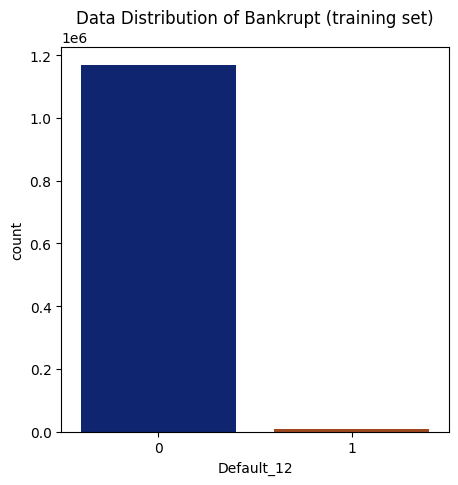

Imbalance Ratio is:124.39087428206764
 % of default is :0.007975062026846492


In [38]:
#Data Imbalance ratio
plt.figure(figsize=(5,5))
sns.countplot(x=cri_compustat_merged["Default_12"], palette="dark")
plt.title("Data Distribution of Bankrupt (training set)")
plt.show()
majority_class_samples=cri_compustat_merged["Default_12"].loc[cri_compustat_merged["Default_12"]==0]
minority_class_samples=cri_compustat_merged["Default_12"].loc[cri_compustat_merged["Default_12"]==1]
Imbalance_Ratio= len(majority_class_samples)/len(minority_class_samples)
percentage = len(minority_class_samples)/(len(minority_class_samples)+len(majority_class_samples))
print(f"Imbalance Ratio is:{Imbalance_Ratio}")
print(f" % of default is :{percentage}") 

In [39]:
cri_compustat_merged.columns

Index(['CompNo', 'year', 'month', 'StkIndx', 'STInt', 'dtdlevel', 'dtdtrend',
       'liqnonfinlevel', 'liqnonfintrend', 'ni2talevel', 'ni2tatrend',
       'sizelevel', 'sizetrend', 'm2b', 'sigma', 'liqfinlevel', 'lqfintrend',
       'DTDmedianFin', 'DTDmedianNonFin', 'dummy297fin', 'StartDate',
       'EventDate', 'Default_1', 'Default_3', 'Default_6', 'Default_12',
       'Default_24', 'Default_36', 'Default_60', 'Duration', 'gvkey', 'tic',
       'current_ratio', 'quick_ratio', 'cash_ratio', 'net_working_capital',
       'debt_ratio', 'debt_to_equity_ratio', 'equity_ratio',
       'cashflow_to_debt_ratio', 'net_profit_margin', 'return_on_assets',
       'asset_turnover', 'inventory_turnover', 'days_in_inventory',
       'receivables_turnover', 'day_sales_outstanding',
       'working_capital_turnover', 'price_to_earnings',
       'dividend_payout_ratio', 'retention_ratio', 'gross_margin_ratio',
       'operating_profit_margin', 'ebitda_margin',
       'debt_service_coverage_ratio', 

In [44]:
with open('../token.json', 'r') as token_file:
    token_data = json.load(token_file)
    project_id = token_data.get('project_id', 'default-project-id')

dataset_id = "capstone"
table_id = 'cri_compustat_data'

to_gbq(cri_compustat_merged, destination_table=f'{project_id}.{dataset_id}.{table_id}', project_id=project_id, if_exists='replace')

100%|██████████| 1/1 [00:00<?, ?it/s]


In [29]:
cri_compustat_merged

,CompNo,year,month,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,day_sales_outstanding,working_capital_turnover,price_to_earnings,dividend_payout_ratio,retention_ratio,gross_margin_ratio,operating_profit_margin,ebitda_margin,debt_service_coverage_ratio,interest_coverage_ratio
0,22043,2015.0,12,-0.007266,-0.010905,2.050583,0.000000,1.555253,0.000000e+00,-0.074437,...,209.926660,0.000000,-3.750000,-0.000000,1.000000,-5.251700e+06,-2.189250e+07,-2.185540e+07,-1.607898,-25.591837
1,22043,2016.0,1,-0.040079,-0.010317,1.907466,-0.143118,1.555253,-2.220446e-16,-0.074437,...,215.036863,-0.645608,-2.333333,-0.000000,1.000000,-3.784182e+02,-8.568365e+02,-8.246649e+02,-149041.103448,-297211.000000
2,22043,2016.0,2,-0.081412,-0.010297,1.735881,-0.343170,1.555253,0.000000e+00,-0.074437,...,215.036863,-0.645608,-2.333333,-0.000000,1.000000,-3.784182e+02,-8.568365e+02,-8.246649e+02,-149041.103448,-297211.000000
3,22043,2016.0,3,-0.003930,-0.010763,1.574717,-0.483492,1.460546,-3.788296e-01,-0.077557,...,216.622596,0.000000,-3.230769,-0.000000,1.000000,-5.251700e+06,-2.189250e+07,-2.185540e+07,-1.315689,-19.537118
4,22043,2016.0,4,-0.019668,-0.010722,1.463769,-0.443790,1.397408,-3.156913e-01,-0.079636,...,216.622596,0.000000,-3.230769,-0.000000,1.000000,-5.251700e+06,-2.189250e+07,-2.185540e+07,-1.315689,-19.537118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179409,93052,2013.0,9,-0.009545,-0.007274,4.892001,1.212125,-0.402310,-8.963039e-03,-0.001001,...,0.000000,-2.837200,64.300000,1.500000,-0.500000,6.804920e+01,3.344428e+01,6.252388e+01,0.100118,15.255908
1179410,93052,2013.0,10,0.030578,-0.007554,4.870839,0.330139,-0.423252,1.197909e-02,-0.001054,...,0.000000,-2.837200,64.300000,1.500000,-0.500000,6.804920e+01,3.344428e+01,6.252388e+01,0.100118,15.255908
1179411,93052,2013.0,11,0.026269,-0.007414,4.842565,0.113506,-0.457056,-1.823057e-01,-0.000853,...,0.000000,-2.837200,64.300000,1.500000,-0.500000,6.804920e+01,3.344428e+01,6.252388e+01,0.100118,15.255908
1179412,93052,2013.0,12,0.023256,-0.007519,4.835230,-0.059513,-0.490860,-1.485018e-01,-0.000653,...,0.000000,-1.877653,96.200000,3.000000,-2.000000,6.061403e+01,1.853357e+01,5.433714e+01,0.046131,12.713643


In [4]:
yfinance = pd.read_pickle("yfinance.pkl")
yfinance

,tic,yyyy,mm,Rolling_Sortino,macd,macd_h,macd_s,rsi
0,AA,2000,12,-0.142575,-6.219730,-1.354880,-4.864850,37.683032
1,AAIC,2000,12,0.055743,-4.929497,-5.491030,0.561532,46.311010
2,ABAX,2000,12,-0.259858,-0.554791,-0.169590,-0.385201,32.262997
3,ABCB,2000,12,-0.312493,-0.252159,-0.105442,-0.146717,30.000000
4,ABCP,2000,12,-0.311491,-0.066055,-0.022023,-0.044032,28.571429
...,...,...,...,...,...,...,...,...
1688969,ZTNO,2023,5,0.301511,-0.145462,0.047282,-0.192744,42.165892
1688970,ZTR,2023,5,-0.514445,-0.845283,-0.150044,-0.695240,28.397041
1688971,ZVOI,2023,5,-0.764450,-0.837910,0.067806,-0.905716,26.351982
1688972,ZYNE,2023,5,-0.762391,-1.118435,0.065407,-1.183842,24.828342


In [5]:
yfinance = yfinance.rename(columns={"yyyy":"year"})
yfinance = yfinance.rename(columns={"mm":"month"})
yfinance

,tic,year,month,Rolling_Sortino,macd,macd_h,macd_s,rsi
0,AA,2000,12,-0.142575,-6.219730,-1.354880,-4.864850,37.683032
1,AAIC,2000,12,0.055743,-4.929497,-5.491030,0.561532,46.311010
2,ABAX,2000,12,-0.259858,-0.554791,-0.169590,-0.385201,32.262997
3,ABCB,2000,12,-0.312493,-0.252159,-0.105442,-0.146717,30.000000
4,ABCP,2000,12,-0.311491,-0.066055,-0.022023,-0.044032,28.571429
...,...,...,...,...,...,...,...,...
1688969,ZTNO,2023,5,0.301511,-0.145462,0.047282,-0.192744,42.165892
1688970,ZTR,2023,5,-0.514445,-0.845283,-0.150044,-0.695240,28.397041
1688971,ZVOI,2023,5,-0.764450,-0.837910,0.067806,-0.905716,26.351982
1688972,ZYNE,2023,5,-0.762391,-1.118435,0.065407,-1.183842,24.828342


In [9]:
cri_compustat_yfinance = cri_compustat_merged.merge(yfinance, on=['tic','year','month'], how='inner')

In [10]:
cri_compustat_yfinance.shape

(579815, 61)

In [11]:
cri_compustat_yfinance.isna().sum()

CompNo             0
year               0
month              0
StkIndx            0
STInt              0
                  ..
Rolling_Sortino    0
macd               0
macd_h             0
macd_s             0
rsi                0
Length: 61, dtype: int64

In [12]:
cri_compustat_yfinance.dropna(inplace=True)

In [13]:
cri_compustat_yfinance.to_pickle("cri_compustat_yfinance.pkl")

In [14]:
with open('../token.json', 'r') as token_file:
    token_data = json.load(token_file)
    project_id = token_data.get('project_id', 'default-project-id')

dataset_id = "capstone"
table_id = 'cri_compustat_yfinance_data'

to_gbq(cri_compustat_yfinance, destination_table=f'{project_id}.{dataset_id}.{table_id}', project_id=project_id, if_exists='replace')

100%|██████████| 1/1 [00:00<?, ?it/s]
